In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# numeric imports
import torch
import numpy as np
# gp imports
import gpytorch
from src.models.sparse.gridded_kronecker_structure import GriddedMatern12ExactGP, GriddedMatern12SVGP, GriddedMatern12ASVGP, GriddedMatern12VFFGP, Matern12GriddedGP
# plotting imports
import matplotlib.pyplot as plt
# util imports
from src.utils.datagenerators import gen_2d
# misc imports
from tqdm import tqdm

# Generate Data

In [2]:
# data generating function
def latent_function_2d(x1, x2):
    return (
        np.sin(5 * x1) + np.cos(7 * x2) +
        0.5 * np.sin(15 * x1) + 0.5 * np.cos(12 * x2) +
        0.2 * np.sin(20 * x1) + 0.2 * np.cos(25 * x2)
    )

In [3]:
# data generating meta
X1LIMS = (0., 1.)
X2LIMS = (0., 1.)
N_OBS = 25 # 25 X 25 = 625 observations
# plotting meta
EXTENT = [X1LIMS[0], X1LIMS[1], X2LIMS[0], X2LIMS[1]]

In [4]:
X, y = gen_2d(latent_function_2d, X1LIMS, X2LIMS, N_OBS)

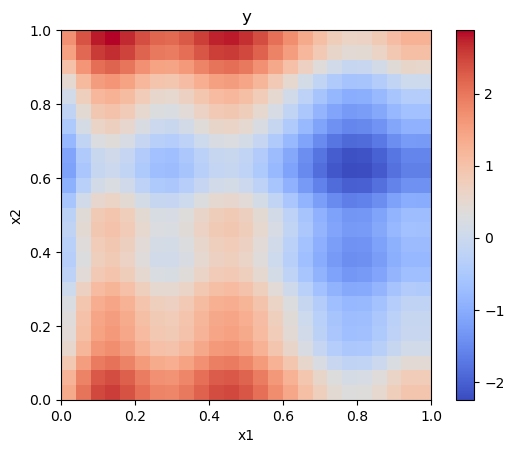

In [5]:
plt.imshow(y.reshape(N_OBS, N_OBS), extent = EXTENT, cmap='coolwarm', origin='upper')
plt.colorbar()
# plot style
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('y');

In [6]:
# training data
X_train = torch.tensor(X).to(torch.float64)
y_train = torch.tensor(y).to(torch.float64)

# Exact GP

In [182]:
exactgp = GriddedMatern12ExactGP(
                        train_x = X_train, train_y = y_train,   
                        n_b0_splines = 10,
                        dim1_grid_lims = (0., 1.), dim2_grid_lims = (0., 1.),).to(torch.float64)

In [188]:
# fit the Exact GP
EXACT_GP_LR = 0.1
EXACT_GP_ITERATIONS = 100
# set model and likelihood into training mode
exactgp.train()
exactgp.likelihood.train()
# define the optimizer
optimizer = torch.optim.Adam(exactgp.parameters(), lr = EXACT_GP_LR)
# define the mll
mll = gpytorch.mlls.ExactMarginalLogLikelihood(exactgp.likelihood, exactgp)
history = torch.zeros(EXACT_GP_ITERATIONS)
for i in tqdm(range(EXACT_GP_ITERATIONS)):
    optimizer.zero_grad()
    output = exactgp(exactgp.train_x)
    loss = -mll(output, exactgp.train_y)
    history[i] = loss.item()
    loss.backward()
    optimizer.step()

# print('='*((5*15) + 4))
# print(f"{'Iteration':^15}|{'Loss':^15}|{'Noise':^15}|{'Lengthscale':^15}|{'Outputscale':^15}")
# print('='*((5*15) + 4))
# print(f"{i+1:^15}|{loss.item():^15.3f}|{exactgp.likelihood.noise.item():^15.3f}|{exactgp.kernel.base_kernel.lengthscale.item():^15.3f}|{exactgp.kernel.outputscale.item():^15.3f}")

100%|██████████| 100/100 [00:03<00:00, 32.70it/s]


# GriddedSVGP

In [7]:
# inducing points
N_INDUCING = 100
Z = torch.tensor(np.random.rand(N_INDUCING, 2), dtype=torch.float64)

In [8]:
gridded_svgp = GriddedMatern12SVGP(
                    X_train, y_train, Z, # data part
                    n_b0_splines=10, # vff part
                    dim1_grid_lims=(0,1), dim2_grid_lims=(0,1)).to(torch.float64) # spline part

In [9]:
gridded_svgp.q_v()

/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
/Users/maxnorman/UCL/dissertation/src/models/sparse/gridded_kronecker_structure.py:291: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343686209/work/aten/src/ATen/native/BucketizationUtils.h:35.)
  indicator = -torch.sign(torch.searchsorted(mesh, x[:, 0], right=False) - k[:, None] - 1)


MultivariateNormal(loc: torch.Size([100]), covariance_matrix: torch.Size([100, 100]))

In [126]:
# fit the VFFGP
LR = 0.01
ITERATIONS = 100
optimizer = torch.optim.Adam(gridded_svgp.parameters(), lr=LR)
# perform gradient descent
svgp_history = torch.empty(ITERATIONS)
for i in tqdm(range(ITERATIONS)):
    optimizer.zero_grad()
    elbow = -gridded_svgp._elbo()
    svgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()
;

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


''

# GriddedVFFGP

In [105]:
# TODO: change names for consistency (i.e nspline -> n_b0_splines)

In [127]:
gridded_vffgp = GriddedMatern12VFFGP(
                    X_train, y_train, # data part
                    nfrequencies=10, vffdim1lims=(-1., 2.), vffdim2lims=(-1., 2.), # vff part
                    nsplines = 10, griddim1lims=(0,1), griddim2lims=(0,1)).to(torch.float64) # spline part

In [128]:
# fit SVGP
LR = 0.01
NITER = 100
optimizer = torch.optim.Adam(gridded_vffgp.parameters(), lr=LR)
# perform gradient descent
history = torch.empty(NITER)
for i in tqdm(range(NITER)):
    optimizer.zero_grad()
    elbow = -gridded_vffgp._elbo()
    history[i] = elbow.item()
    elbow.backward()
    optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


# GriddedASVGP

In [144]:
N_B0SPLINES = 10
PADDING_FACTOR = 0
gridded_asvgp = GriddedMatern12ASVGP(X_train, y_train, N_B0SPLINES, PADDING_FACTOR, (0,1), (0,1))

In [149]:
# # fit SVGP
# LR = 0.01
# NITER = 100
# optimizer = torch.optim.Adam(gridded_asvgp.parameters(), lr=LR)
# # perform gradient descent
# asvgp_history = torch.empty(NITER)
# for i in tqdm(range(NITER)):
#     optimizer.zero_grad()
#     elbow = -gridded_asvgp._elbo()
#     asvgp_history[i] = elbow.item()
#     elbow.backward()
#     optimizer.step()

# GriddedGP (Mine)

In [133]:
N_KNOTS = 11
GRIDDEDDIM1LIMS = (0, 1) # TODO: Need to add padding to this model -> otherwise breaks
GRIDDEDDIM2LIMS = (0, 1)

In [134]:
griddedgp = Matern12GriddedGP(X_train, y_train, N_KNOTS, GRIDDEDDIM1LIMS, GRIDDEDDIM2LIMS).to(torch.float64)

In [135]:
# fit SVGP
LR = 0.01
NITER = 100
optimizer = torch.optim.Adam(griddedgp.parameters(), lr=LR)
# perform gradient descent
griddedgp_history = torch.empty(NITER)
for i in tqdm(range(NITER)):
    optimizer.zero_grad()
    elbow = -griddedgp._elbo()
    griddedgp_history[i] = elbow.item()
    elbow.backward()
    optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


# Model Comparison

In [146]:
exactgp_grid_pred = exactgp.q_v()
svgp_grid_pred = gridded_svgp.q_v()
vffgp_grid_pred = gridded_vffgp.q_v()
asvgp_grid_pred = gridded_asvgp.q_v()
grid_pred = griddedgp.q_v()

AttributeError: 'Axes' object has no attribute 'colorbar'

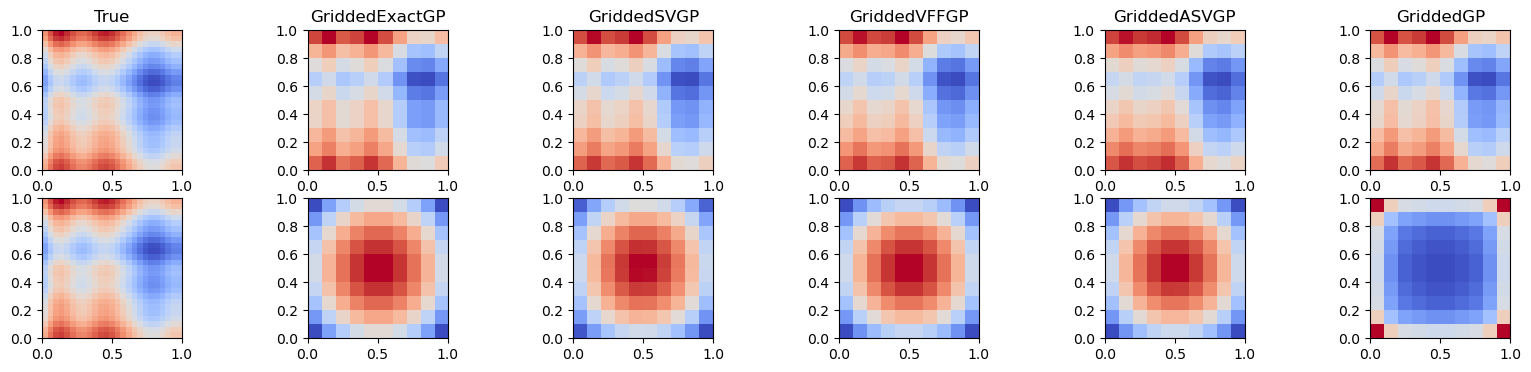

In [154]:
fig, ((ax1, ax2, ax3, ax4, ax5, ax6), (ax7, ax8, ax9, ax10, ax11, ax12)) = plt.subplots(2, 6, figsize=(20, 4))

# plot true
ax1.imshow(y.reshape(25, 25), origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax7.imshow(y.reshape(25, 25), origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax1.set_title('True')

# plot exactgp
ax2.imshow(exactgp_grid_pred.mean.detach().numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax8.imshow(torch.diagonal(exactgp_grid_pred.covariance_matrix.detach()).numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax2.set_title('GriddedExactGP')

# plot svgp
ax3.imshow(svgp_grid_pred.mean.detach().numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax9.imshow(torch.diagonal(svgp_grid_pred.covariance_matrix.detach()).numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax3.set_title('GriddedSVGP')

# plot vffgp
ax4.imshow(vffgp_grid_pred.mean.detach().numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax10.imshow(torch.diagonal(vffgp_grid_pred.covariance_matrix.detach()).numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax4.set_title('GriddedVFFGP')

# plot asvgp
ax5.imshow(asvgp_grid_pred.mean.detach().numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax11.imshow(torch.diagonal(asvgp_grid_pred.covariance_matrix.detach()).numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax5.set_title('GriddedASVGP')

# plot griddedgp
ax6.imshow(grid_pred.mean.detach().numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax12.imshow(torch.diagonal(grid_pred.covariance_matrix.detach()).numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
ax6.set_title('GriddedGP')


Text(0.5, 1.0, 'GriddedGP')

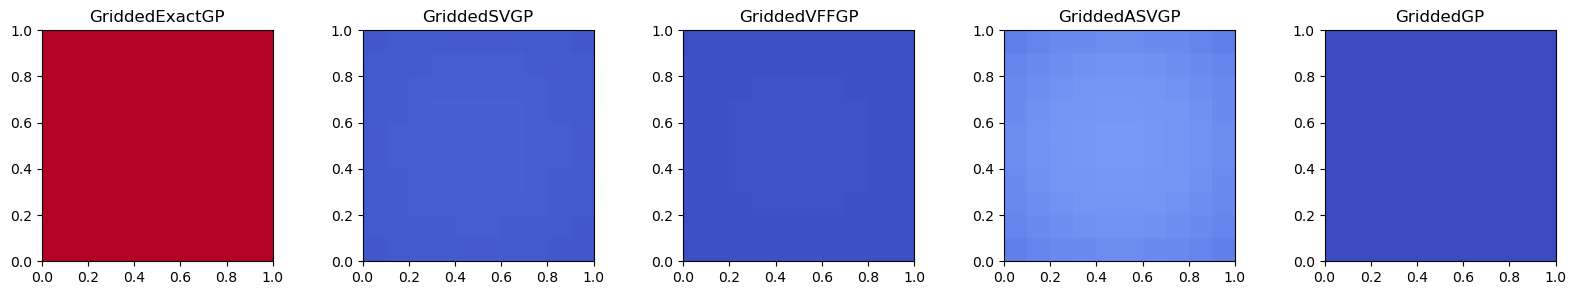

In [175]:
fig, (ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 5, figsize=(20, 3))

# plot true
# ax1.imshow(y.reshape(25, 25), origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm')
# ax1.set_title('True')
vmin = 0
vmax = 1

# plot exactgp
ax2.imshow(torch.diagonal(exactgp_grid_pred.covariance_matrix.detach()).numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm', vmin=vmin, vmax=vmax)
ax2.set_title('GriddedExactGP')

# plot svgp
ax3.imshow(torch.diagonal(svgp_grid_pred.covariance_matrix.detach()).numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm', vmin=vmin, vmax=vmax)
ax3.set_title('GriddedSVGP')

# plot vffgp
ax4.imshow(torch.diagonal(vffgp_grid_pred.covariance_matrix.detach()).numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm', vmin=vmin, vmax=vmax)
ax4.set_title('GriddedVFFGP')

# plot asvgp
ax5.imshow(torch.diagonal(asvgp_grid_pred.covariance_matrix.detach()).numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm', vmin=vmin, vmax=vmax)
ax5.set_title('GriddedASVGP')

# plot griddedgp
ax6.imshow(torch.diagonal(grid_pred.covariance_matrix.detach()).numpy().reshape(10, 10).T, origin='upper', extent=[0, 1, 0, 1], cmap='coolwarm', vmin=vmin, vmax=vmax)
ax6.set_title('GriddedGP')

In [170]:
torch.diagonal(exactgp_grid_pred.covariance_matrix.detach()).numpy().min()

877.2060493492759

In [171]:
torch.diagonal(exactgp_grid_pred.covariance_matrix.detach()).numpy().max()

941.5257019488184